TLDR:

Evaluate a northern us location at december solstice.
Plot diffuse irradiance
Implement Rich solar 24V and 24V panels
Look at margins for MPPT turn on


# Purpose
This notebook evaluates and compares the yields of flat angled, open rack mounted, prototypic 12V (nominal) solar panels (PV modules) arranged in a series and parallel configuration controlled by a prototypic maximum power point tracking solar charge controller charging a prototypic lithium-iron-phosphate 12V (nominal) battery.  Unique to this evaluation versus any others I am aware of is explicitly accounting for the required PV module voltage above battery voltage which can limit solar power production during cloudy and near sunrise or sunset conditions.

# General Approach
All modeling is performed using [pvlib](https://pvlib-python.readthedocs.io/en/stable/index.html).  PV module models used for the evaluation will be based on Rich Solar 12V and 24V 200W panel performance.  The maximum power point tracking (MPPT) solar charge controller model is based on the stated performance of Victron Smart Solar MPPT line.  Battery voltage is consistent with a 12V lithium-iron-phosphate (LFP) chemistry.  Wiring voltage drops will be based on current and advertised resistance for Ancor marine wire of applicable gauges.

In [6]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## Solar Panels
Rich Solar brand 200W panels were selected based on thier common employment within the marine and RV communities, and thier employment in my campervan.  Unfortunately, full technical information (e.g. voltge and current temperature coefficients) to model the performance of these panels is not available within the CEC database of PV modules, and Rich Solar did not respond to a request for these details.  In lieu of direct data, a PV module from the CEC database that closely matches the Rich Solar 24V nominal 200W panel was selected (CEC data base key: 'JA_Solar_JAM5_L__72_200_SI').

|Parameter|Rich Solar 24V 200W|'JA_Solar_JAM5_L__72_200_SI'|
|---------|:-----------------:|---------------------------:|
|STC      |200W               |200.0862W                   |
|Cells    |72                 |72                          |
|I_sc     |5.83A              |5.66A                       |
|V_oc     |45.4V              |45.62V                      |
|I_mp     |5.32A              |5.37A                       |
|V_mp     |37.6V              |37.26V                      |

All parameters of the 'JA_Solar_JAM5_L__72_200_SI' module were scaled or calculated to approximate the Rich Solar 12V panel stated performance. 

In [7]:
# Get the module parameters for 'JA_Solar_JAM5_L__72_200_SI' from the CEC database
MODULE_24 = pvlib.pvsystem.retrieve_sam('CECMod')['JA_Solar_JAM5_L__72_200_SI']

# Create a dictionary of the parameters to represent the 24V Rich Solar module
rich_solar_24V_params = {
    'Name' : 'Rich Solar 24V',
    'Technology': MODULE_24['Technology'],
    'Bifacial' : MODULE_24['Bifacial'],
    'STC' : MODULE_24['STC'],
    'PTC' : MODULE_24['PTC'],
    'A_c' : MODULE_24['A_c'],
    'Length' : MODULE_24['Length'],
    'Width' : MODULE_24['Width'],
    'N_s' : MODULE_24['N_s'],
    'I_sc_ref' : MODULE_24['I_sc_ref'],
    'V_oc_ref' : MODULE_24['V_oc_ref'],
    'I_mp_ref' : MODULE_24['I_mp_ref'],
    'V_mp_ref' : MODULE_24['V_mp_ref'],
    'alpha_sc' : MODULE_24['alpha_sc'],
    'beta_oc' : MODULE_24['beta_oc'],
    'gamma_r' : MODULE_24['gamma_r'],
    'T_NOCT' : MODULE_24['T_NOCT'],
    'a_ref' : MODULE_24['a_ref'],
    'I_L_ref' : MODULE_24['I_L_ref'],
    'I_o_ref' : MODULE_24['I_o_ref'],
    'R_s' : MODULE_24['R_s'],
    'R_sh_ref' : MODULE_24['R_sh_ref'],
    'Adjust' : MODULE_24['Adjust']
}

# Create a dictionary of the parameters to represent the 12V Rich Solar module
# Scale the paremters that can be easily scaled
rich_solar_12V_params = {
    'Name' : 'Rich Solar 12V',
    'Technology': MODULE_24['Technology'],
    'Bifacial' : MODULE_24['Bifacial'],
    'STC' : MODULE_24['STC'],
    'PTC' : MODULE_24['PTC'],
    'A_c' : MODULE_24['A_c']*2,
    'Length' : MODULE_24['Length'],
    'Width' : MODULE_24['Width'],
    'N_s' : MODULE_24['N_s']/2,
    'I_sc_ref' : MODULE_24['I_sc_ref']*2,
    'V_oc_ref' : MODULE_24['V_oc_ref']/2,
    'I_mp_ref' : MODULE_24['I_mp_ref']*2,
    'V_mp_ref' : MODULE_24['V_mp_ref']/2,
    'alpha_sc' : MODULE_24['alpha_sc']*2,
    'beta_oc' : MODULE_24['beta_oc']/2,
    'gamma_r' : MODULE_24['gamma_r'],
    'T_NOCT' : MODULE_24['T_NOCT'],
}

# Caculate the remaining parameters for the 12V module
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = pvlib.ivtools.sdm.fit_cec_sam(
                                                                         celltype='monoSi',
                                                                         v_mp=rich_solar_12V_params['V_mp_ref'],
                                                                         i_mp=rich_solar_12V_params['I_mp_ref'],
                                                                         v_oc=rich_solar_12V_params['V_oc_ref'],
                                                                         i_sc=rich_solar_12V_params['I_sc_ref'],
                                                                         alpha_sc=rich_solar_12V_params['alpha_sc'],
                                                                         beta_voc=rich_solar_12V_params['beta_oc'],
                                                                         gamma_pmp=rich_solar_12V_params['gamma_r'],
                                                                         cells_in_series=rich_solar_12V_params['N_s']
                                                                         )

# Add the calculated parameters to the dictionary representing the 12V Rich Solar module
rich_solar_12V_params['a_ref'] = a_ref
rich_solar_12V_params['I_L_ref'] = I_L_ref
rich_solar_12V_params['I_o_ref'] = I_o_ref
rich_solar_12V_params['R_s'] = R_s
rich_solar_12V_params['R_sh_ref'] = R_sh_ref
rich_solar_12V_params['Adjust'] = Adjust

In [8]:

# Add a few more constants
EgRef = 1.121 #The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon.
dEgdT = -0.0002677 #The temperature dependence of the energy bandgap at reference conditions in units of 1/K. -0.0002677 1/K for crystalline silicon.
Temp = 25 #Cell temperature in degrees C
#TODO we should base this on the average december soltice temperature for the location

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

## Solar Charge Controller
The charge controller is modeled using a [user defined inverter model](https://pvlib-python.readthedocs.io/en/stable/user_guide/modelchain.html#user-defined-models) to allow gating of solar power production based on input voltage.  The behavior of the charge controller model is based on the Victron Smart Solar line due to its common employment within the marine and RV communities, and employment in my campervan.  Based on rating of PV systems modeled, I selected the Smart Solar 10/50 varient.

From the [Smart Solar 100/50 and 100/30 Manual](https://www.victronenergy.com/media/pg/Manual_SmartSolar_MPPT_100-30__100-50/en/operation.html):
>The solar charger will commence battery charging as soon as the PV voltage is 5V higher than the battery voltage. For charging to continue, the PV voltage must remain at least 1V higher than the battery voltage.  

This behavior will be captured in charge controller model.  

From the [Smart Solar 100/50 and 100/30 Datasheet]() charge controller efficiency exceeds 98%.  The model will use a value of 98% for controller efficiency (c_eff).

### Wiring Effects
When producing power, the PV-side voltage observed by the charge controller will be the PV system maximum power voltage (V_mp) reduced by the voltage drop in the module-to-charge controller wires equal to the wire resistance (R_pv_wire) times the PV system maximum power current (I_mp).

Likewise, the battery-side voltage observed by the charge controller will be the battery voltage (V_batt) increased by the voltage drop in the charge-controller-to-battery wires equal to the wire resistance (R_batt_wire) times the battery side current.  The battery side current will be calculated as the as a quadratic function of product of PV system power (P_mp) and controller efficiency (c_eff) divided by battery voltage (V_batt).

If modelchain.
### Battery Voltage Effects
Battery voltage will be a fixed by a parameter and will not vary throughout a charge, effectively simulating a battery with infinite capacity.  A value of 14.4 is a commonly recommended absorption/bulk voltage for LFP batteries by many suppliers (which is too high IMO).  The higher the voltage, the more challenging it will be for a controller to initiate and maintain solar power production, thus a value like 14.4V is conservative.  A more realistic voltage for a battery that has been discharging overnight is 13.3V.

### Loss effects
TODO think about how to handle losses.  The charge controller model will already have everything to calculate both the controller loss and the ohmic losses.  We could use a user defined function that replicates the calcs of the charge controller.  Or we could set the results by the controller function.  We could also make a singleton function that holds the losses.  We also need to decide on how to divide them up.  I think powered delivered at the end of the battey side wire is what should be reported.

Based on discussions with pvlib maintainers, we will handle losses as follows:
The AC power reported by the user defined model is intended to be the power delivered at the end of the wires connecting to the battery or DC system.  As such, battery-side DC wire losses and losses due to MPPT efficiency are reflected in the difference between modelchain.result.dc and modelchain.result.ac.

## DC Ohmic Loss (PV-side only)
The PV-side Ohmic loss is modeled using a [user defined dc_ohmic_loss model]().

When producing power, the PV-side voltage observed by the charge controller will be the PV system maximum power voltage (V_mp) reduced by the voltage drop in the module-to-charge controller wires equal to the wire resistance (R_pv_wire) times the PV system maximum power current (I_mp).

The PV-side DC wire losses are reflected in modelchain.result.dc_ohmic_losses and are subtracted from modelchain.result.dc prior to the model chain running the ac model.  Likewise, this loss model modifies v_mp in modelchain.result.dc to reflect the voltage drop between the PV modules and the MPPT.

pvlib does not inlcude a kwarg for dc_ohmic_loss_params, so parameters should be provided during system instantiation as part of inverter_parameters.

### Implementation

`v_batt`, `v_start`, `v_continue`, `r_batt_wire`, and `r_pv_wire`, are passed in a dict-like object via the PVSystem kwarg `inverter_parameters`.  



In [9]:
def custom_dc_ohmic_loss(model_chain):
    try:
        pv_wire_resistance = model_chain.system.inverter_parameters['r_pv_wire']
    except KeyError:
        raise ValueError('could not set PV Wire resistance from '
                         'system.inverter_parameters. Check '
                         'system.inverter_parameters.')
    p_ohmic = model_chain.result.dc['i_mpp']**2 * pv_wire_resistance
    
    p_mp = model_chain.results.dc['p_mp']
    v_mp = model_chain.results.dc['v_mp']
    i_mp = model_chain.results.dc['i_mp']

    p_ohmic = i_mp**2 * pv_wire_resistance
    #p_mp = p_mp - p_ohmic
    v_ohmic = v_mp - i_mp * pv_wire_resistance

    if isinstance(p_mp, pd.Series):
        p_ohmic = pd.Series(p_ohmic, index=p_mp.index)
        
    # set values in results.dc
    #model_chain.results.dc['p_mp'] = p_mp
    #model_chain.results.dc['v_mp'] = v_mp

    # must set values in model chain directly
    model_chain.results.dc_ohmic_losses['p_ohmic'] = p_ohmic
    model_chain.results.dc_ohmic_losses['v_ohmic'] = v_ohmic

    return model_chain

    

Setup

Because pvlib doesn't have a clean inverter class, and inverter use/selection/functions are spread between PVSystem and ModelChain, we have to subclass both.
Subclass PVSystem to allow for custom inverter type

I think we can define a function and pass it to ModelChain for calculating AC


In [10]:
V_BATT = 14.2
V_MPPT_START = V_BATT + 5
V_MPPT_CONTINUE = V_BATT + 1

In [11]:
# need to mod to look at voc and see if that changes things at least for  turn on

def mppt(model_chain):
    p_mp = model_chain.results.dc['p_mp']
    v_mp = model_chain.results.dc['v_mp']
    v_oc = model_chain.results.dc['v_oc']

    power_ac = np.empty_like(p_mp)
    # hard coding voltage limits for now
    v_start = V_MPPT_START
    v_continue = V_MPPT_CONTINUE
    v_threshold = v_start
    on = False
    for i, (vmp, voc, pmp) in enumerate(zip(v_mp, v_oc, p_mp)):
        if on:
            if vmp < v_continue:
                on = False
                power_ac[i] = 0
            else:
                power_ac[i] = pmp
        else:
            if voc >= v_start:
                on = True
                power_ac[i] = pmp
            
    if isinstance(p_mp, pd.Series):
        power_ac = pd.Series(power_ac, index=p_mp.index)
        
    # must set value in model chain directly
    model_chain.results.ac = power_ac


    


In [12]:
# evaluate hood river, oregon and key west, florida

# latitude, longitude, name, altitude, timezone
coordinates = [(45.71417626139969, -121.5154782530592, 'Hood River', 27, 'Etc/GMT+8'),
               (24.58321, -81.76675, 'Key West', 4, 'Etc/GMT+5')]

# get Typical Meteorological Year (TMY) data
tmys = []
for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)
    


In [13]:
# #weather['utc_time'] = weather.index.map(lambda d: d.replace(year=2000))
for weather in tmys:
    weather.index = pd.to_datetime(weather.index.to_series().apply(lambda d: d.replace(year=2022)))
# #print(weather.to_string())
# #print(type(weather))
# key_west = tmys[1]
# key_west = key_west.tz_convert('US/Eastern')

# key_west_single_day = key_west.loc['2022-01-04 00:00:00':'2022-01-04 23:59:59']
# # Resample to minute-level data
# key_west_single_day = key_west_single_day.resample('1T')

# # Interpolate missing minute-level data using polynomial interpolation
# key_west_single_day = key_west_single_day.interpolate(method='polynomial', order=1)
# key_west_single_day.plot(y=['ghi', 'dni', 'dhi'])
# interpolate whether data to be minute level

tmys = [weather.resample('1min').interpolate(method='polynomial', order=1) for weather in tmys]

# get december data
tmys_dec = [weather.loc['2022-12-01 00:00:00':'2022-12-31 23:59:59'] for weather in tmys]
# get june data
tmys_jun = [weather.loc['2022-06-01 00:00:00':'2022-06-30 23:59:59'] for weather in tmys]


#



In [14]:
mppt_via_adr_inverter_params = {
    'Pnom' : 500,
    'Vnom' : 25,
    'Vmax' : 80,
    'Vmin' : 0,
    'Vdcmax' : 80,
    'MPPTHi' : 80,
    'MPPTLow' : 13.9+5,
    'Pacmax' : 500,
    'ADRCoefficients' : [0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Pnt' : 0
}

# December Data

Energy Parallel (KW-hr)=
 Hood River     7.928184
Key West      46.122667
dtype: float64
Energy Series (KW-hr)=
 Hood River     7.935987
Key West      46.123508
dtype: float64
Energy Parallel 24V (KW-hr)=
 Hood River     7.935986
Key West      46.123518
dtype: float64
Delta (KW-hr)=
 Hood River   -0.007803
Key West     -0.000841
dtype: float64


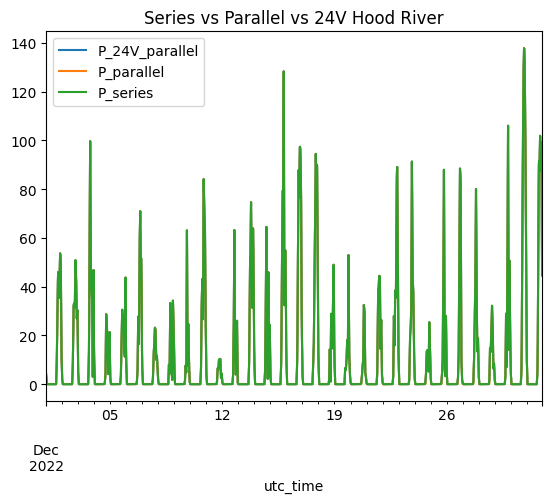

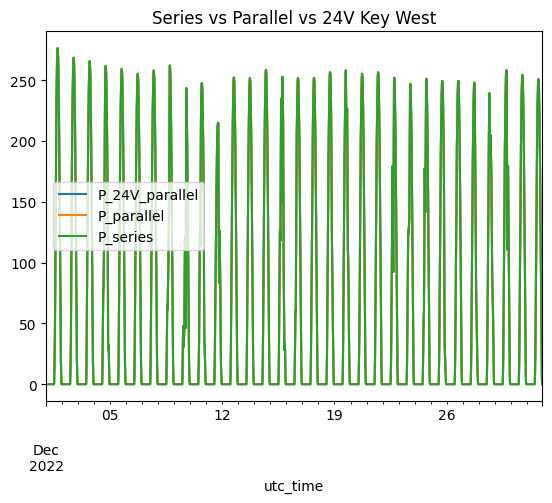

In [15]:
energiesParallel = {}
energiesSeries = {}
energies24VParallel = {}

#run december data
for location, weather in zip(coordinates, tmys_dec):
    latitude, longitude, name, altitude, timezone = location
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
        )
    mount = FixedMount(
        surface_tilt=0,
        surface_azimuth=180,
        )
    arrayParallel = Array(
        mount=mount,
        module_parameters=rich_solar_12V_params,
        temperature_model_parameters=temperature_model_parameters,
        strings=2,
    )
    arraySeries = Array(
        mount=mount,
        module_parameters=rich_solar_12V_params,
        temperature_model_parameters=temperature_model_parameters,
        strings=1,
        modules_per_string=2,
    )
    array24VParallel = Array(
        mount=mount,
        module_parameters=rich_solar_24V_params,
        temperature_model_parameters=temperature_model_parameters,
        strings=2,
    )
    systemParallel = PVSystem(arrays=[arrayParallel], inverter_parameters=mppt_via_adr_inverter_params)
    systemSeries = PVSystem(arrays=[arraySeries], inverter_parameters=mppt_via_adr_inverter_params)
    system24VParallel = PVSystem(arrays=[array24VParallel], inverter_parameters=mppt_via_adr_inverter_params)
    mcSeries = ModelChain(systemSeries, location, aoi_model="physical", spectral_model="no_loss", ac_model=mppt)
    mcParallel = ModelChain(systemParallel, location, aoi_model="physical", spectral_model="no_loss", ac_model=mppt)
    mc24VParallel = ModelChain(system24VParallel, location, aoi_model="physical", spectral_model="no_loss", ac_model=mppt)

    mcParallel.run_model(weather)
    mcSeries.run_model(weather)
    mc24VParallel.run_model(weather)

    #plot
    plt.figure()
    mc24VParallel.results.ac.plot(label='P_24V_parallel')
    mcParallel.results.ac.plot(label='P_parallel')
    mcSeries.results.ac.plot(title='Series vs Parallel vs 24V '+name, label='P_series')
    
    plt.legend()

    #print('mc24VParallel.results.ac', mc24VParallel.results.ac)

    annual_energy_parallel = mcParallel.results.ac.sum()/60000.0
    annual_energy_series = mcSeries.results.ac.sum()/60000.0
    annual_energy_24V_parallel = mc24VParallel.results.ac.sum()/60000.0
    energiesParallel[name] = annual_energy_parallel
    energiesSeries[name] = annual_energy_series
    energies24VParallel[name] = annual_energy_24V_parallel

energiesParallel = pd.Series(energiesParallel)
energiesSeries = pd.Series(energiesSeries)
energies24VParallel = pd.Series(energies24VParallel)
print('Energy Parallel (KW-hr)=\n', energiesParallel)
print('Energy Series (KW-hr)=\n', energiesSeries)
print('Energy Parallel 24V (KW-hr)=\n', energies24VParallel)
delta = energiesParallel - energiesSeries
print('Delta (KW-hr)=\n', delta)

# June Data

Energy Parallel (KW-hr)=
 Hood River    74.429403
Key West      68.218574
dtype: float64
Energy Series (KW-hr)=
 Hood River    74.445983
Key West      68.219915
dtype: float64
Energy Parallel 24V (KW-hr)=
 Hood River    74.446003
Key West      68.219940
dtype: float64
Delta (KW-hr)=
 Hood River   -0.016580
Key West     -0.001341
dtype: float64


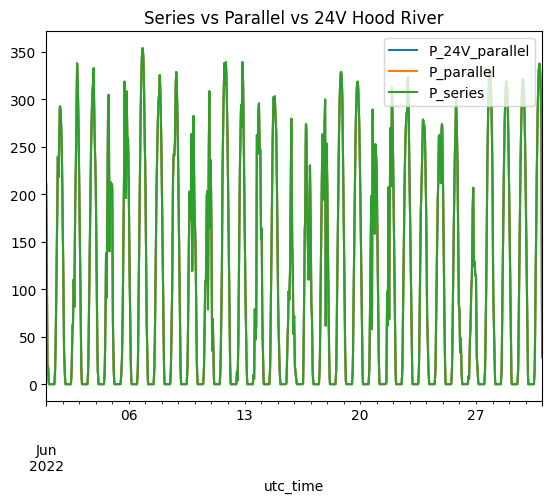

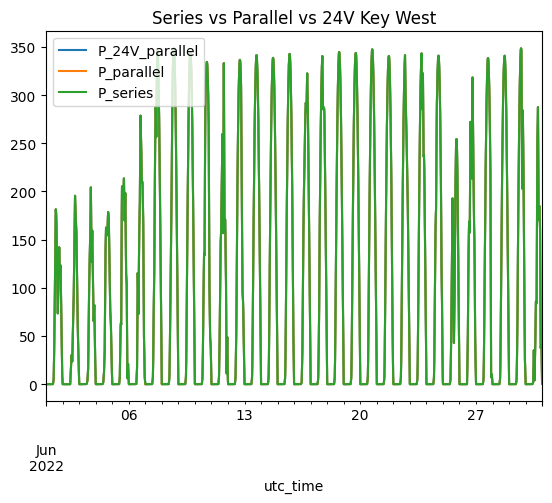

In [16]:
energiesParallel = {}
energiesSeries = {}
energies24VParallel = {}

#run december data
for location, weather in zip(coordinates, tmys_jun):
    latitude, longitude, name, altitude, timezone = location
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
        )
    mount = FixedMount(
        surface_tilt=0,
        surface_azimuth=180,
        )
    arrayParallel = Array(
        mount=mount,
        module_parameters=rich_solar_12V_params,
        temperature_model_parameters=temperature_model_parameters,
        strings=2,
    )
    arraySeries = Array(
        mount=mount,
        module_parameters=rich_solar_12V_params,
        temperature_model_parameters=temperature_model_parameters,
        strings=1,
        modules_per_string=2,
    )
    array24VParallel = Array(
        mount=mount,
        module_parameters=rich_solar_24V_params,
        temperature_model_parameters=temperature_model_parameters,
        strings=2,
    )
    systemParallel = PVSystem(arrays=[arrayParallel], inverter_parameters=mppt_via_adr_inverter_params)
    systemSeries = PVSystem(arrays=[arraySeries], inverter_parameters=mppt_via_adr_inverter_params)
    system24VParallel = PVSystem(arrays=[array24VParallel], inverter_parameters=mppt_via_adr_inverter_params)
    mcSeries = ModelChain(systemSeries, location, aoi_model="physical", spectral_model="no_loss", ac_model=mppt)
    mcParallel = ModelChain(systemParallel, location, aoi_model="physical", spectral_model="no_loss", ac_model=mppt)
    mc24VParallel = ModelChain(system24VParallel, location, aoi_model="physical", spectral_model="no_loss", ac_model=mppt)

    mcParallel.run_model(weather)
    mcSeries.run_model(weather)
    mc24VParallel.run_model(weather)

    #plot
    plt.figure()
    mc24VParallel.results.ac.plot(label='P_24V_parallel')
    mcParallel.results.ac.plot(label='P_parallel')
    mcSeries.results.ac.plot(title='Series vs Parallel vs 24V '+name, label='P_series')
    
    plt.legend()

    #print('mc24VParallel.results.ac', mc24VParallel.results.ac)

    annual_energy_parallel = mcParallel.results.ac.sum()/60000.0
    annual_energy_series = mcSeries.results.ac.sum()/60000.0
    annual_energy_24V_parallel = mc24VParallel.results.ac.sum()/60000.0
    energiesParallel[name] = annual_energy_parallel
    energiesSeries[name] = annual_energy_series
    energies24VParallel[name] = annual_energy_24V_parallel
    
energiesParallel = pd.Series(energiesParallel)
energiesSeries = pd.Series(energiesSeries)
energies24VParallel = pd.Series(energies24VParallel)
print('Energy Parallel (KW-hr)=\n', energiesParallel)
print('Energy Series (KW-hr)=\n', energiesSeries)
print('Energy Parallel 24V (KW-hr)=\n', energies24VParallel)
delta = energiesParallel - energiesSeries
print('Delta (KW-hr)=\n', delta)

Look at a single day of Key West in June

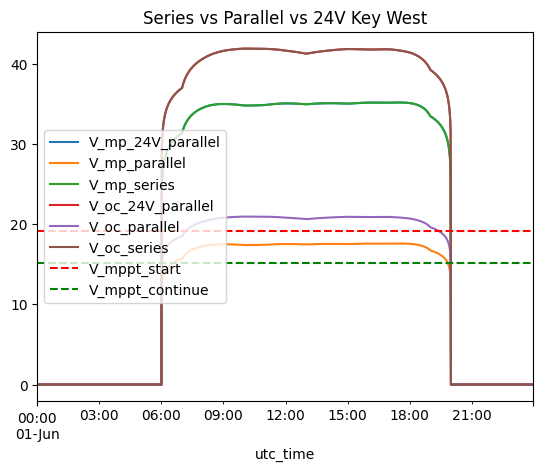

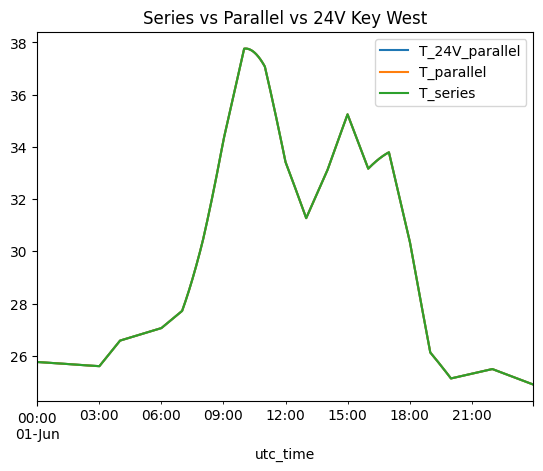

In [17]:
key_west = tmys[1]
key_west = key_west.tz_convert('US/Eastern')
key_west_single_day = key_west.loc['2022-06-01 00:00:00':'2022-06-01 23:59:59']

mcParallel.run_model(key_west_single_day)
mcSeries.run_model(key_west_single_day)
mc24VParallel.run_model(key_west_single_day)

plt.figure()
mc24VParallel.results.dc['v_mp'].plot(label='V_mp_24V_parallel')
mcParallel.results.dc['v_mp'].plot(label='V_mp_parallel')
mcSeries.results.dc['v_mp'].plot(title='Series vs Parallel vs 24V '+name, label='V_mp_series')
mc24VParallel.results.dc['v_oc'].plot(label='V_oc_24V_parallel')
mcParallel.results.dc['v_oc'].plot(label='V_oc_parallel')
mcSeries.results.dc['v_oc'].plot(label='V_oc_series')

plt.axhline(V_MPPT_START, color='r', linestyle='--', label='V_mppt_start')
plt.axhline(V_MPPT_CONTINUE, color='g', linestyle='--', label='V_mppt_continue')
plt.legend()

plt.figure()
mc24VParallel.results.cell_temperature.plot(label='T_24V_parallel')
mcParallel.results.cell_temperature.plot(label='T_parallel')
mcSeries.results.cell_temperature.plot(title='Series vs Parallel vs 24V '+name, label='T_series')
plt.legend()


# Same for Hood River

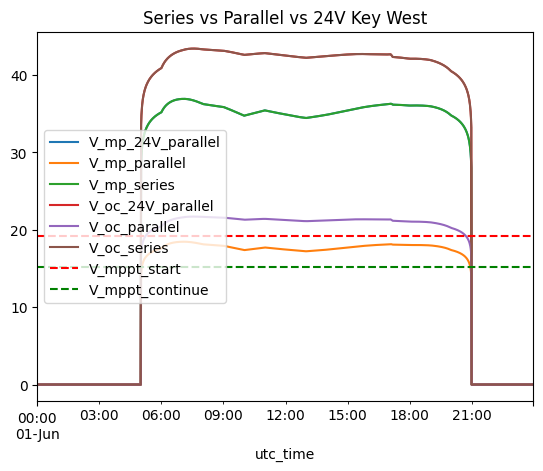

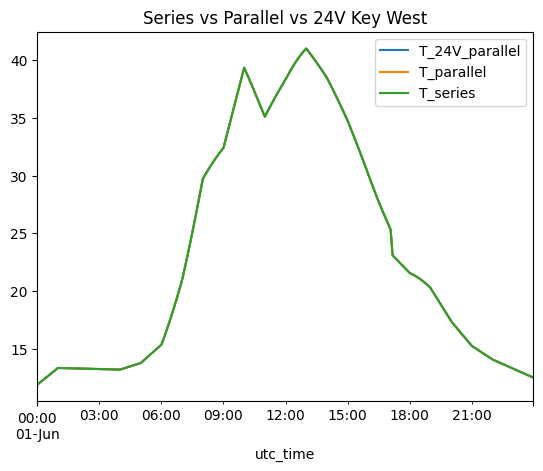

In [18]:
hood_river = tmys[0]
hood_river = hood_river.tz_convert('US/Pacific')
hood_river_single_day = hood_river.loc['2022-06-01 00:00:00':'2022-06-01 23:59:59']

mcParallel.run_model(hood_river_single_day)
mcSeries.run_model(hood_river_single_day)
mc24VParallel.run_model(hood_river_single_day)

plt.figure()
mc24VParallel.results.dc['v_mp'].plot(label='V_mp_24V_parallel')
mcParallel.results.dc['v_mp'].plot(label='V_mp_parallel')
mcSeries.results.dc['v_mp'].plot(title='Series vs Parallel vs 24V '+name, label='V_mp_series')
mc24VParallel.results.dc['v_oc'].plot(label='V_oc_24V_parallel')
mcParallel.results.dc['v_oc'].plot(label='V_oc_parallel')
mcSeries.results.dc['v_oc'].plot(label='V_oc_series')

plt.axhline(V_MPPT_START, color='r', linestyle='--', label='V_mppt_start')
plt.axhline(V_MPPT_CONTINUE, color='g', linestyle='--', label='V_mppt_continue')
plt.legend()

plt.figure()
mc24VParallel.results.cell_temperature.plot(label='T_24V_parallel')
mcParallel.results.cell_temperature.plot(label='T_parallel')
mcSeries.results.cell_temperature.plot(title='Series vs Parallel vs 24V '+name, label='T_series')
plt.legend()

Looking at first week in january in Key West to figure out why Parallel 24V is so high

<Axes: xlabel='utc_time'>

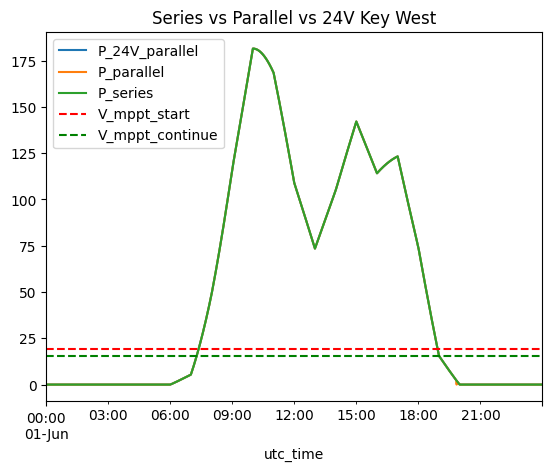

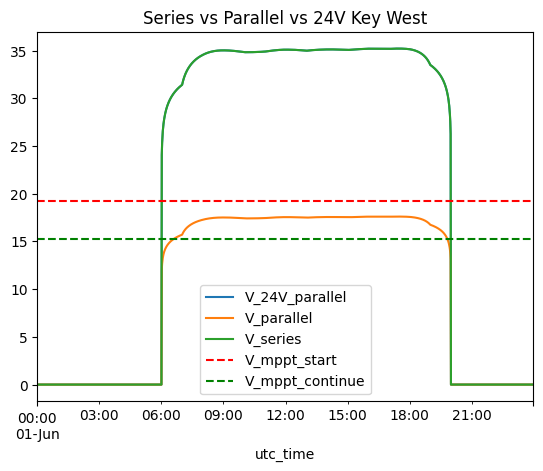

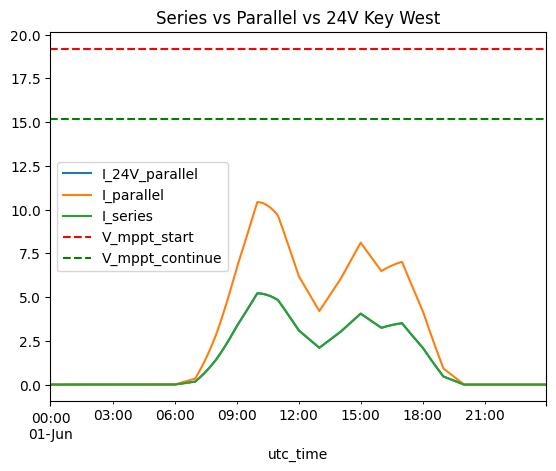

<Figure size 640x480 with 0 Axes>

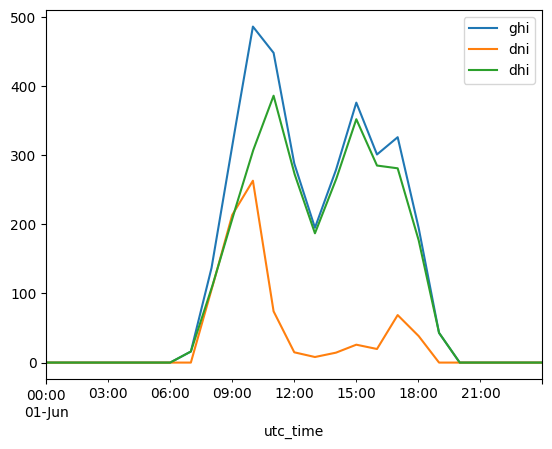

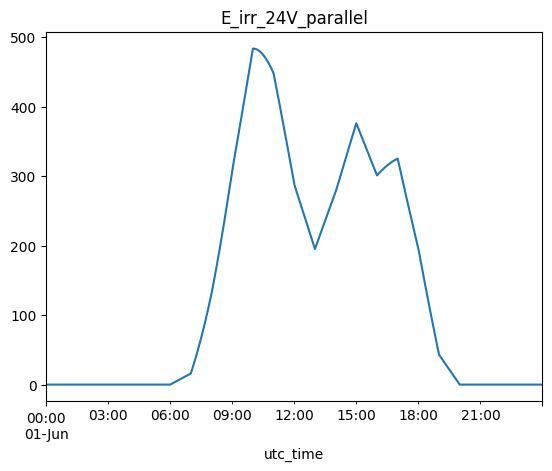

<Figure size 640x480 with 0 Axes>

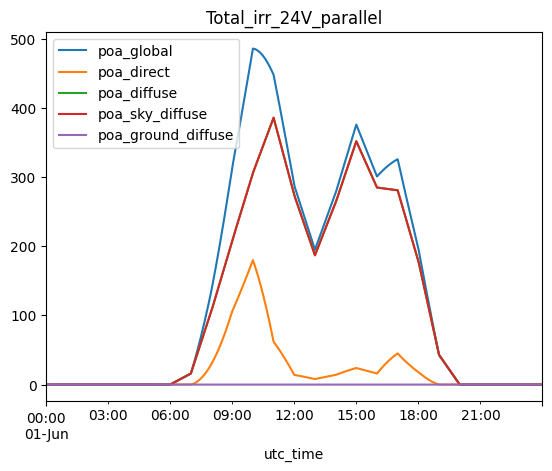

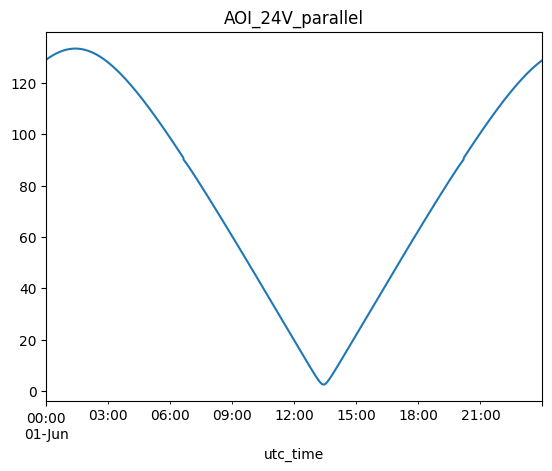

<Figure size 640x480 with 0 Axes>

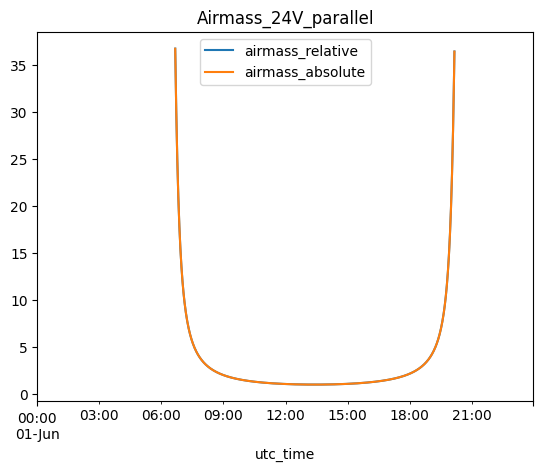

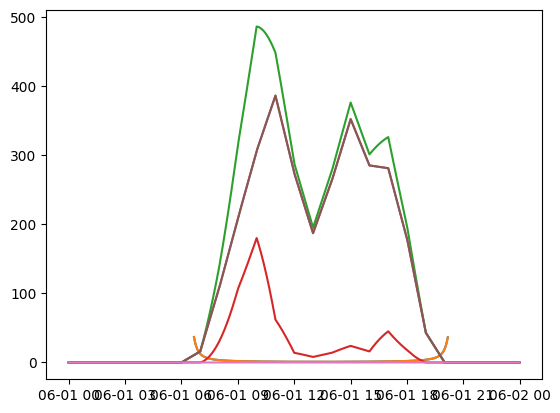

<Figure size 640x480 with 0 Axes>

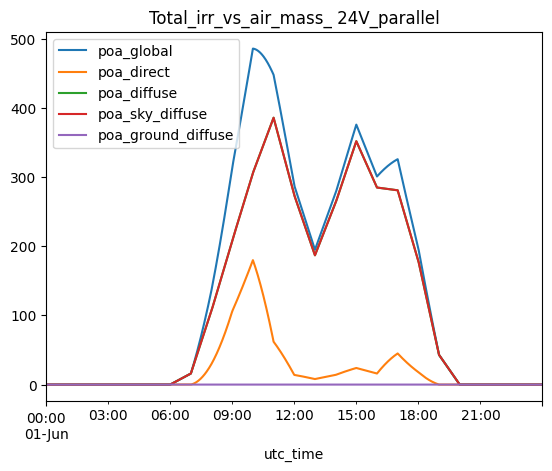

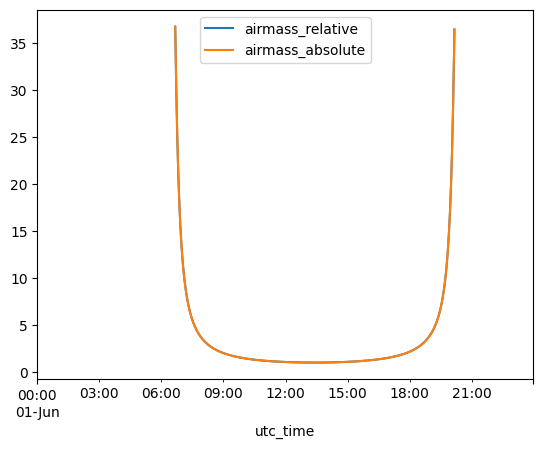

In [19]:
mcParallel.run_model(key_west_single_day)
mcSeries.run_model(key_west_single_day)
mc24VParallel.run_model(key_west_single_day)

#plot
plt.figure()
mc24VParallel.results.ac.plot(label='P_24V_parallel')
mcParallel.results.ac.plot(label='P_parallel')
mcSeries.results.ac.plot(title='Series vs Parallel vs 24V '+name, label='P_series')
plt.axhline(V_MPPT_START, color='r', linestyle='--', label='V_mppt_start')
plt.axhline(V_MPPT_CONTINUE, color='g', linestyle='--', label='V_mppt_continue')
plt.legend()

plt.figure()
mc24VParallel.results.dc['v_mp'].plot(label='V_24V_parallel')
mcParallel.results.dc['v_mp'].plot(label='V_parallel')
mcSeries.results.dc['v_mp'].plot(title='Series vs Parallel vs 24V '+name, label='V_series')
plt.axhline(V_MPPT_START, color='r', linestyle='--', label='V_mppt_start')
plt.axhline(V_MPPT_CONTINUE, color='g', linestyle='--', label='V_mppt_continue')
plt.legend()

plt.figure()
mc24VParallel.results.dc['i_mp'].plot(label='I_24V_parallel')
mcParallel.results.dc['i_mp'].plot(label='I_parallel')
mcSeries.results.dc['i_mp'].plot(title='Series vs Parallel vs 24V '+name, label='I_series')
plt.axhline(V_MPPT_START, color='r', linestyle='--', label='V_mppt_start')
plt.axhline(V_MPPT_CONTINUE, color='g', linestyle='--', label='V_mppt_continue')
plt.legend()


plt.figure()
key_west_single_day.plot(y=['ghi', 'dni', 'dhi'])

plt.figure()
mc24VParallel.results.effective_irradiance.plot(title='E_irr_24V_parallel')

plt.figure()
mc24VParallel.results.total_irrad.plot(title='Total_irr_24V_parallel')

plt.figure()
mc24VParallel.results.aoi.plot(title='AOI_24V_parallel')

#plt.figure()
#mc24VParallel.results.solar_position.plot(title='Solar Position_24V_parallel')


plt.figure()
mc24VParallel.results.airmass.plot(title='Airmass_24V_parallel')

plt.figure()
plt.plot(mc24VParallel.results.airmass)
plt.plot(mc24VParallel.results.total_irrad)

plt.figure()
mc24VParallel.results.total_irrad.plot(title='Total_irr_vs_air_mass_ 24V_parallel')
mc24VParallel.results.airmass.plot()



Lets look at December solstice in Hood river

parallelEnergy= 538.3867682381076  Wh
seriesEnergy= 538.4075791030165  Wh
parallel24VEnergy= 538.4077009643275  Wh


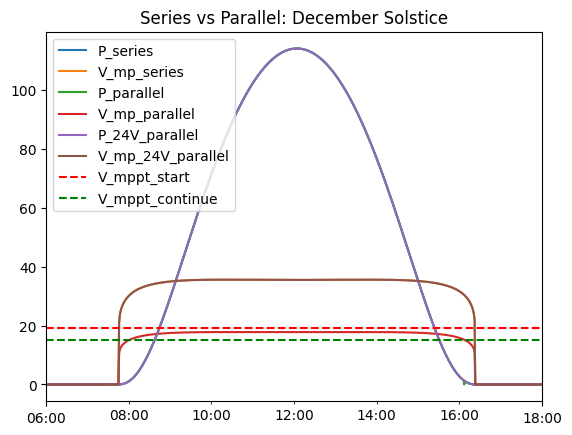

In [20]:
loc = Location(45.71417626139969, -121.5154782530592, name='Hood River', altitude=27, tz='Etc/GMT+8')
mcSeries = ModelChain(systemSeries, loc, aoi_model="physical", spectral_model="no_loss", ac_model=mppt)
mcParallel = ModelChain(systemParallel, loc, aoi_model="physical", spectral_model="no_loss", ac_model=mppt)
mc24VParallel = ModelChain(system24VParallel, loc, aoi_model="physical", spectral_model="no_loss", ac_model=mppt)
times = pd.date_range(start='2019-12-21 06:00', end='2019-12-21 18:00', freq='1min', tz=loc.tz)
weather = loc.get_clearsky(times)
mcSeries.run_model(weather)
mcParallel.run_model(weather)
mc24VParallel.run_model(weather)

#print totals
parallelEnergy = mcParallel.results.ac.sum()
print('parallelEnergy=', parallelEnergy/60, ' Wh')
seriesEnergy = mcSeries.results.ac.sum()
print('seriesEnergy=', seriesEnergy/60, ' Wh')
parallel24VEnergy = mc24VParallel.results.ac.sum()
print('parallel24VEnergy=', parallel24VEnergy/60, ' Wh')

#debug
#print('series results ac=',mcSeries.results.ac)

#plot series
mcSeries.results.ac.plot(title='Series vs Parallel: December Solstice', label='P_series')
mcSeries.results.dc['v_mp'].plot(label='V_mp_series')
mcParallel.results.ac.plot(label='P_parallel')
mcParallel.results.dc['v_mp'].plot(label='V_mp_parallel')
mc24VParallel.results.ac.plot(label='P_24V_parallel')
mc24VParallel.results.dc['v_mp'].plot(label='V_mp_24V_parallel')

plt.axhline(V_MPPT_START, color='r', linestyle='--', label='V_mppt_start')
plt.axhline(V_MPPT_CONTINUE, color='g', linestyle='--', label='V_mppt_continue')
plt.legend()


Now look at June Solstice in Hood River

parallelEnergy= 2957.036083683922  Wh
seriesEnergy= 2958.050325420892  Wh
parallel24VEnergy= 2958.0513175023107  Wh


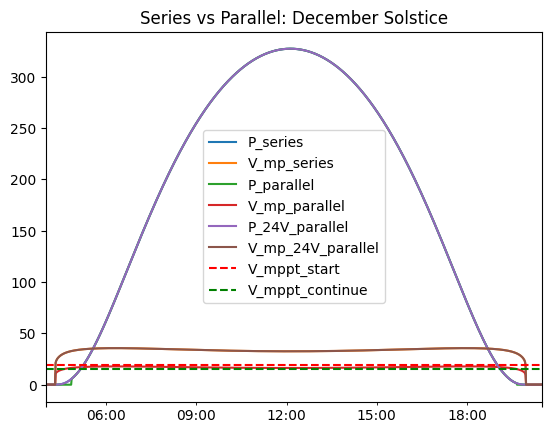

In [21]:
times = pd.date_range(start='2019-06-20 04:00', end='2019-06-20 20:30', freq='1min', tz=loc.tz)
weather = loc.get_clearsky(times)
mcSeries.run_model(weather)
mcParallel.run_model(weather)
mc24VParallel.run_model(weather)

#print totals
parallelEnergy = mcParallel.results.ac.sum()
print('parallelEnergy=', parallelEnergy/60, ' Wh')
seriesEnergy = mcSeries.results.ac.sum()
print('seriesEnergy=', seriesEnergy/60, ' Wh')
parallel24VEnergy = mc24VParallel.results.ac.sum()
print('parallel24VEnergy=', parallel24VEnergy/60, ' Wh')

#debug
#print('series results ac=',mcSeries.results.ac)

#plot series
mcSeries.results.ac.plot(title='Series vs Parallel: December Solstice', label='P_series')
mcSeries.results.dc['v_mp'].plot(label='V_mp_series')
mcParallel.results.ac.plot(label='P_parallel')
mcParallel.results.dc['v_mp'].plot(label='V_mp_parallel')
mc24VParallel.results.ac.plot(label='P_24V_parallel')
mc24VParallel.results.dc['v_mp'].plot(label='V_mp_24V_parallel')

plt.axhline(V_MPPT_START, color='r', linestyle='--', label='V_mppt_start')
plt.axhline(V_MPPT_CONTINUE, color='g', linestyle='--', label='V_mppt_continue')
plt.legend()

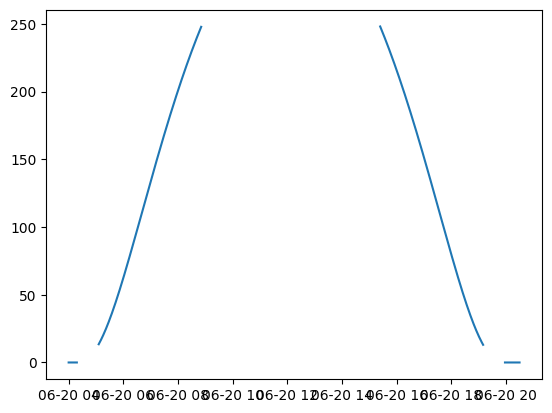

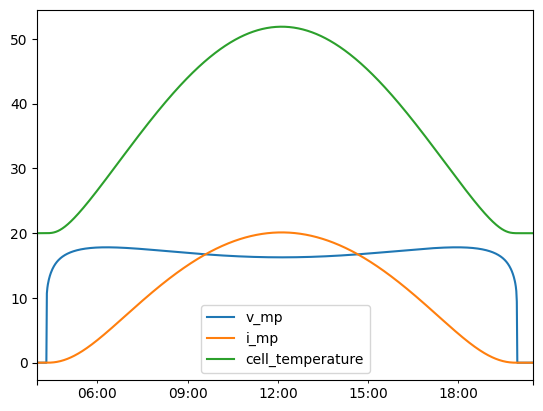

In [22]:
adr_inverter_params = {
    'Pnom' : 400,
    'Vnom' : 30,
    'Vmax' : 60,
    'Vmin' : 0,
    'Vdcmax' : 60,
    'MPPTHi' : 60,
    'MPPTLow' : 13.9+5,
    'Pacmax' : 400,
    'ADRCoefficients' : [0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Pnt' : 0
}

pac = pvlib.pvsystem.inverter.adr(mcParallel.results.dc.v_mp, mcParallel.results.dc.p_mp, adr_inverter_params)
plt.plot(pac)
plt.show()
plt.figure()
mcParallel.results.dc.v_mp.plot(label='v_mp')
mcParallel.results.dc.i_mp.plot(label='i_mp')
mcParallel.results.cell_temperature.plot(label='cell_temperature')
plt.legend()

#mcParallel.results.ac.plot(label='parallel')

For the 24V Rich Solar Panel, based on its datasheet, the closest CEC database entry is "JA Solar JAM5(L)-72-200/SI" which is keyed in the database as `'JA_Solar_JAM5_L__72_200_SI'`.

For the 24V Rich Solar Panel, there isn't a close entry.  For that panel, we'll scale the appropriate parameters and then use pvlib to calculate the rest.


Next we will use the desoto model to calculate the parameters for the different irradiance levels.

In [23]:
cases = [
    (1000, Temp),
    (800, Temp),
    (600, Temp),
    (400, Temp),
    (200, Temp),
    (100, Temp),
    #(50, Temp),
    #(25, Temp),
    #(12, Temp)
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=rich_solar_24V_params['alpha_sc'],
    a_ref=rich_solar_24V_params['a_ref'],
    I_L_ref=rich_solar_24V_params['I_L_ref'],
    I_o_ref=rich_solar_24V_params['I_o_ref'],
    R_sh_ref=rich_solar_24V_params['R_sh_ref'],
    R_s=rich_solar_24V_params['R_s'],
    EgRef=EgRef, 
    dEgdT=-dEgdT
)

{'photocurrent': 0    5.720156
1    4.576125
2    3.432094
3    2.288062
4    1.144031
5    0.572016
dtype: float64, 'saturation_current': 0    3.803987e-10
1    3.803987e-10
2    3.803987e-10
3    3.803987e-10
4    3.803987e-10
5    3.803987e-10
dtype: float64, 'resistance_series': 0    0.490811
1    0.490811
2    0.490811
3    0.490811
4    0.490811
5    0.490811
dtype: float64, 'resistance_shunt': 0     789.011169
1     986.263961
2    1315.018615
3    1972.527922
4    3945.055845
5    7890.111690
dtype: float64, 'nNsVth': 0    1.947605
1    1.947605
2    1.947605
3    1.947605
4    1.947605
5    1.947605
dtype: float64}


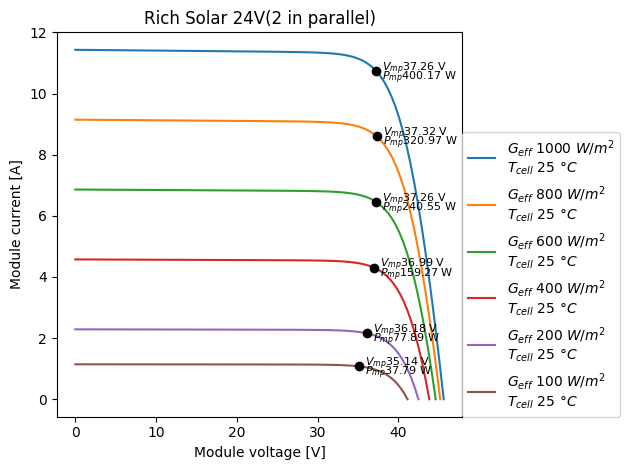

In [24]:
# plug the parameters into the SDE and solve for IV curves:
SDE_params = {
    'photocurrent': IL,
    'saturation_current': I0,
    'resistance_series': Rs,
    'resistance_shunt': Rsh,
    'nNsVth': nNsVth
}

print(SDE_params)

curve_info = pvlib.pvsystem.singlediode(method='lambertw', **SDE_params)
v = pd.DataFrame(np.linspace(0., curve_info['v_oc'], 100))
i = pd.DataFrame(pvlib.pvsystem.i_from_v(voltage=v, method='lambertw', **SDE_params))

# plot the calculated curves:
plt.figure()
for idx, case in conditions.iterrows():
    label = (
        "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
        "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
    )
    plt.plot(v[idx], i[idx]+i[idx], label=label)
    v_mp = curve_info['v_mp'][idx]
    i_mp = curve_info['i_mp'][idx]
    # mark the MPP
    plt.plot([v_mp], [2*i_mp], ls='', marker='o', c='k')
    plt.text(v_mp * 1.02, 2*i_mp, f"$V_{{mp}}${v_mp:.2f} V", fontsize=8)
    plt.text(v_mp * 1.02, 2*i_mp - 0.3, f"$P_{{mp}}${2*i_mp*v_mp:.2f} W", fontsize=8)

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title(rich_solar_24V_params['Name'] + '(2 in parallel)')
plt.gcf().set_tight_layout(True)


{'photocurrent': 0    11.440312
1     9.152250
2     6.864187
3     4.576125
4     2.288062
5     1.144031
dtype: float64, 'saturation_current': 0    7.608256e-10
1    7.608256e-10
2    7.608256e-10
3    7.608256e-10
4    7.608256e-10
5    7.608256e-10
dtype: float64, 'resistance_series': 0    0.122702
1    0.122702
2    0.122702
3    0.122702
4    0.122702
5    0.122702
dtype: float64, 'resistance_shunt': 0     197.254445
1     246.568057
2     328.757409
3     493.136114
4     986.272227
5    1972.544455
dtype: float64, 'nNsVth': 0    0.973804
1    0.973804
2    0.973804
3    0.973804
4    0.973804
5    0.973804
dtype: float64}


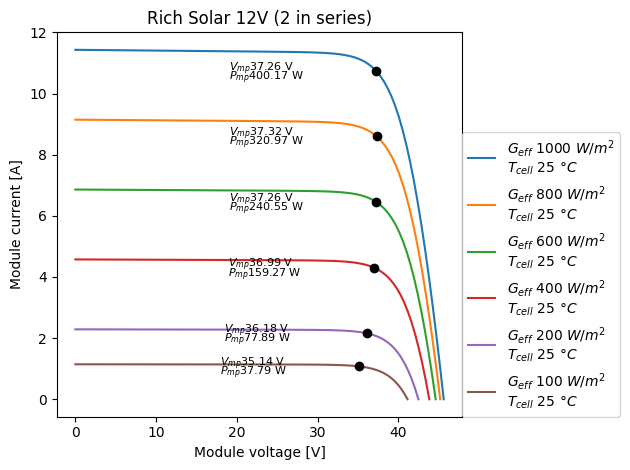

In [25]:
cases = [
    (1000, Temp),
    (800, Temp),
    (600, Temp),
    (400, Temp),
    (200, Temp),
    (100, Temp),
    #(50, Temp),
    #(25, Temp),
    #(12, Temp)
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=rich_solar_12V_params['alpha_sc'],
    a_ref=rich_solar_12V_params['a_ref'],
    I_L_ref=rich_solar_12V_params['I_L_ref'],
    I_o_ref=rich_solar_12V_params['I_o_ref'],
    R_sh_ref=rich_solar_12V_params['R_sh_ref'],
    R_s=rich_solar_12V_params['R_s'],
    EgRef=EgRef, 
    dEgdT=-dEgdT
)

# plug the parameters into the SDE and solve for IV curves:
SDE_params = {
    'photocurrent': IL,
    'saturation_current': I0,
    'resistance_series': Rs,
    'resistance_shunt': Rsh,
    'nNsVth': nNsVth
}

print(SDE_params)

curve_info = pvlib.pvsystem.singlediode(method='lambertw', **SDE_params)
v = pd.DataFrame(np.linspace(0., curve_info['v_oc'], 100))
i = pd.DataFrame(pvlib.pvsystem.i_from_v(voltage=v, method='lambertw', **SDE_params))

# plot the calculated curves:
plt.figure()
for idx, case in conditions.iterrows():
    label = (
        "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
        "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
    )
    plt.plot(v[idx] + v[idx], i[idx], label=label)
    v_mp = curve_info['v_mp'][idx]
    i_mp = curve_info['i_mp'][idx]
    # mark the MPP
    plt.plot([v_mp*2], [i_mp], ls='', marker='o', c='k')
    plt.text(v_mp * 1.02, i_mp, f"$V_{{mp}}${v_mp*2:.2f} V", fontsize=8)
    plt.text(v_mp * 1.02, i_mp - 0.3, f"$P_{{mp}}${i_mp*v_mp*2:.2f} W", fontsize=8)

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title(rich_solar_12V_params['Name'] + " (2 in series)")
plt.gcf().set_tight_layout(True)

In [26]:
print('rich_solar_12V_params=', rich_solar_12V_params)
print('rich_solar_24V_params=', rich_solar_24V_params)

rich_solar_12V_params= {'Name': 'Rich Solar 12V', 'Technology': 'Mono-c-Si', 'Bifacial': 0, 'STC': 200.0862, 'PTC': 178.5, 'A_c': 2.554, 'Length': 1.58, 'Width': 0.808, 'N_s': 36.0, 'I_sc_ref': 11.32, 'V_oc_ref': 22.81, 'I_mp_ref': 10.74, 'V_mp_ref': 18.63, 'alpha_sc': 0.006962, 'beta_oc': -0.080428, 'gamma_r': -0.4567, 'T_NOCT': 47.6, 'a_ref': 0.973804158972974, 'I_L_ref': 11.44031204496401, 'I_o_ref': 7.608255760344541e-10, 'R_s': 0.12270248066631148, 'R_sh_ref': 197.25444549468273, 'Adjust': 7.669332700388107}
rich_solar_24V_params= {'Name': 'Rich Solar 24V', 'Technology': 'Mono-c-Si', 'Bifacial': 0, 'STC': 200.0862, 'PTC': 178.5, 'A_c': 1.277, 'Length': 1.58, 'Width': 0.808, 'N_s': 72, 'I_sc_ref': 5.66, 'V_oc_ref': 45.62, 'I_mp_ref': 5.37, 'V_mp_ref': 37.26, 'alpha_sc': 0.003481, 'beta_oc': -0.160856, 'gamma_r': -0.4567, 'T_NOCT': 47.6, 'a_ref': 1.947605, 'I_L_ref': 5.720156, 'I_o_ref': 3.803987e-10, 'R_s': 0.490811, 'R_sh_ref': 789.011169, 'Adjust': 7.668952}


A function to plot diffuse and direct POA

In [27]:
def plot_diffuse_POA():
    surface_tilt = 0
    sigsbee = location.Location(24.5833, -81.767, 'US/Eastern', 0, 'Sigsbee Park')
    times = pd.date_range(start='2024-01-20 00:01', 
                          end='2024-01-20 23:59', 
                          freq='1min', 
                          tz=sigsbee.tz)
    sunrise_sunset = sigsbee.get_sun_rise_set_transit(times, method='spa')

    sunrise = sunrise_sunset['sunrise'][0]
    sunset = sunrise_sunset['sunset'][0]
    times = pd.date_range(start=sunrise, 
                          end=sunset, 
                          freq='1min', 
                          tz=sigsbee.tz)
    cs = sigsbee.get_clearsky(times)
    solpos = sigsbee.get_solarposition(times)
    pvSys = pvsystem.PVSystem(surface_tilt=surface_tilt)
    irradiance = pvSys.get_irradiance(solpos['zenith'], 
                                      solpos['azimuth'], 
                                      cs['ghi'], 
                                      cs['dni'], 
                                      cs['dhi'])
    plt.figure()
    plt.title('Diffuse POA Irradiance vs. Solar Zenith Angle')
    ax = plt.plot(times,irradiance['poa_diffuse'])
    plt.plot(times,irradiance['poa_direct'])
    date_form = dates.DateFormatter("%H:%M", tz=sigsbee.tz)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(date_form)
    plt.xlim(sunrise, sunset)
    plt.ylim(0)
    plt.show()

plot_diffuse_POA()

AttributeError: 'Location' object has no attribute 'Location'

## Factcheck: Panel Voltage is a Function Incident Light - True in a irrelevant way

It is commonly stated in posts related to solar panels that 

>Connecting your solar panels in series is often preferred if you’re able to spend most of your time in unshaded locations. The main reason for this is that your solar panel system will be more efficient and will perform better at the beginning and end of the day and when it’s cloudy. Here’s why.
>
>Batteries require a higher voltage than their nominal voltage to charge. For example, our lithium batteries need 14.4 volts to start charging. Most solar panels in the 100-watt range have an output voltage between 18-20 volts. To reach the 14.4 volts required to charge your batteries, solar panels in parallel would need to be operating at 75% capacity or more. - [Battleborn](https://battlebornbatteries.com/solar-panels-in-series-or-parallel/)

While Panel Voltage (both open circuit and max power) depend heavily on panel temperature, the dependance on incident light is negligable except at the lowest levels of light.  This is best shown in a figure produced from this (slightly modified) pvlib [example](https://pvlib-python.readthedocs.io/en/v0.10.3/gallery/iv-modeling/plot_singlediode.html#sphx-glr-gallery-iv-modeling-plot-singlediode-py):

For perspective, at sunrise on a cloudy day, the diffuse light is approximately X.

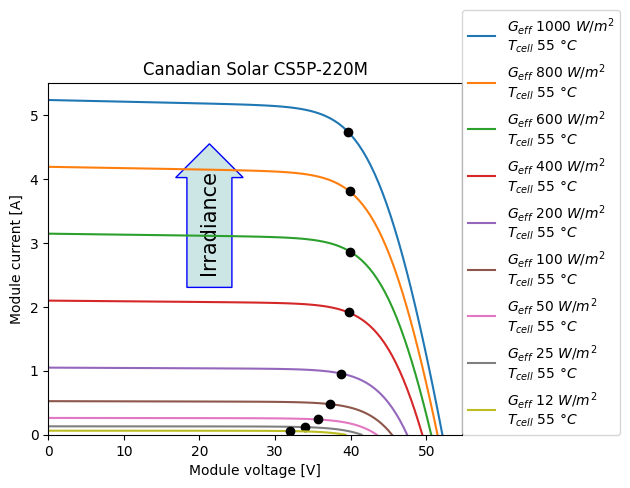

       i_sc       v_oc      i_mp       v_mp        p_mp
0  5.235561  52.129783  4.742475  39.614016  187.868473
1  4.190781  51.483033  3.805721  39.867812  151.725757
2  3.144837  50.649228  2.861983  39.956701  114.355380
3  2.097727  49.474044  1.912108  39.735026   75.977656
4  1.049448  47.465051  0.957075  38.741473   37.078494
5  0.524871  45.456055  0.478155  37.310421   17.840155
6  0.262472  43.447057  0.238622  35.662183    8.509786
7  0.131245  41.438056  0.118991  33.908766    4.034839
8  0.063000  39.310735  0.056913  31.999742    1.821204


In [ ]:
# Example module parameters for the Canadian Solar CS5P-220M:
parameters = {
    'Name': 'Canadian Solar CS5P-220M',
    'BIPV': 'N',
    'Date': '10/5/2009',
    'T_NOCT': 42.4,
    'A_c': 1.7,
    'N_s': 96,
    'I_sc_ref': 5.1,
    'V_oc_ref': 59.4,
    'I_mp_ref': 4.69,
    'V_mp_ref': 46.9,
    'alpha_sc': 0.004539,
    'beta_oc': -0.22216,
    'a_ref': 2.6373,
    'I_L_ref': 5.114,
    'I_o_ref': 8.196e-10,
    'R_s': 1.065,
    'R_sh_ref': 381.68,
    'Adjust': 8.7,
    'gamma_r': -0.476,
    'Version': 'MM106',
    'PTC': 200.1,
    'Technology': 'Mono-c-Si',
}

cases = [
    (1000, 55),
    (800, 55),
    (600, 55),
    (400, 55),
    (200, 55),
    (100, 55),
    (50, 55),
    (25, 55),
    (12, 55)
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

# adjust the reference parameters according to the operating
# conditions using the De Soto model:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=parameters['alpha_sc'],
    a_ref=parameters['a_ref'],
    I_L_ref=parameters['I_L_ref'],
    I_o_ref=parameters['I_o_ref'],
    R_sh_ref=parameters['R_sh_ref'],
    R_s=parameters['R_s'],
    EgRef=1.121,
    dEgdT=-0.0002677
)

# plug the parameters into the SDE and solve for IV curves:
SDE_params = {
    'photocurrent': IL,
    'saturation_current': I0,
    'resistance_series': Rs,
    'resistance_shunt': Rsh,
    'nNsVth': nNsVth
}
curve_info = pvsystem.singlediode(method='lambertw', **SDE_params)
v = pd.DataFrame(np.linspace(0., curve_info['v_oc'], 100))
i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method='lambertw', **SDE_params))

# plot the calculated curves:
plt.figure()
for idx, case in conditions.iterrows():
    label = (
        "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
        "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
    )
    plt.plot(v[idx], i[idx], label=label)
    v_mp = curve_info['v_mp'][idx]
    i_mp = curve_info['i_mp'][idx]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.xlim(0)
plt.ylim(0)
plt.title(parameters['Name'])
plt.gcf().set_tight_layout(True)


# draw trend arrows
def draw_arrow(ax, label, x0, y0, rotation, size, direction):
    style = direction + 'arrow'
    bbox_props = dict(boxstyle=style, fc=(0.8, 0.9, 0.9), ec="b", lw=1)
    t = ax.text(x0, y0, label, ha="left", va="bottom", rotation=rotation,
                size=size, bbox=bbox_props, zorder=-1)

    bb = t.get_bbox_patch()
    bb.set_boxstyle(style, pad=0.6)


ax = plt.gca()
draw_arrow(ax, 'Irradiance', 20, 2.5, 90, 15, 'r')
# draw_arrow(ax, 'Temperature', 35, 1, 0, 15, 'l')
plt.show()

print(pd.DataFrame({
    'i_sc': curve_info['i_sc'],
    'v_oc': curve_info['v_oc'],
    'i_mp': curve_info['i_mp'],
    'v_mp': curve_info['v_mp'],
    'p_mp': curve_info['p_mp'],
}))

In [ ]:
import numpy as np
inv_params = {
    'Paco' : 100,
    'Pdco' : 100,
    'Vdco' : 15,
    'Pso' : 1,
    'C0' : .5,
    'C1' : -1,
    'C2' : 1,
    'C3' : 0,
    'Pnt' : -1
}

vdc = np.linspace(0, 40, 100)
pdc = np.linspace(0, 500, 100)
pac = inverter.sandia(vdc, pdc, inv_params)
plt.plot(vdc, pac)
plt.ylim(-10, 110)
plt.show()
pac
pdc

NameError: name 'inverter' is not defined

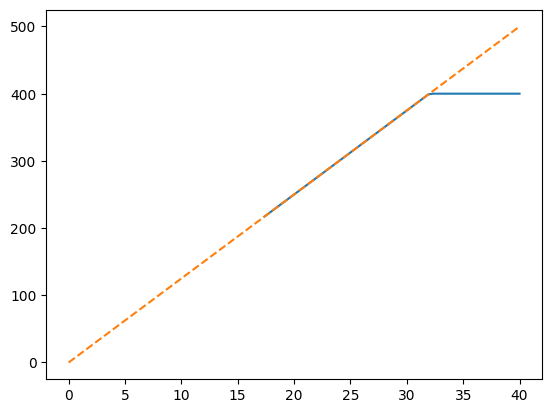

array([  0.        ,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, 217.17171717,
       222.22222222, 227.27272727, 232.32323232, 237.37373737,
       242.42424242, 247.47474747, 252.52525253, 257.57575758,
       262.62626263, 267.67676768, 272.72727273, 277.77777778,
       282.82828283, 287.87878788, 292.92929293, 297.97979798,
       303.03030303, 308.08080808, 313.13131313, 318.18

In [ ]:
adr_inverter_params = {
    'Pnom' : 400,
    'Vnom' : 25,
    'Vmax' : 60,
    'Vmin' : 0,
    'Vdcmax' : 60,
    'MPPTHi' : 60,
    'MPPTLow' : 13.9+5,
    'Pacmax' : 400,
    'ADRCoefficients' : [0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Pnt' : 0
}

pac = pvlib.pvsystem.inverter.adr(vdc, pdc, adr_inverter_params)

plt.plot(vdc, pac)
plt.plot(vdc, pdc, '--')
plt.show()
pac

Run a december solstice case in hood river oregon with a single 12v and 24v rich solar panel into a victron MPPT on a 24V system
